In [1]:
#libraries import
import os
import glob

from dotenv import load_dotenv #Required for using API
from openai import OpenAI #Required when programming usings ollama

from transformers import AutoTokenizer
from langchain_chroma import Chroma

#from langchain_openai import OpenAIEmbeddings, ChatOpenAI #Embeddings & LLM Models
from langchain.embeddings import HuggingFaceEmbeddings #Loads pretrained embeddings from Hugging Face models (e.g., BERT, SentenceTransformers).

import numpy as np
import matplotlib as plt #python lib for ploting graphs
from sklearn.manifold import TSNE #t-SNE (t-distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique.Use Case: Helps visualize high-dimensional embeddings in 2D/3D
import plotly.graph_objects as go #Used for interactive 3D visualization of embeddings.


In [2]:
MODEL ='llama3.2'
db_name = "vector_db"

In [19]:
#Add your data to be tokenized
# Sample C and Python code
text = [
    "#include <stdio.h>\nint main() {", 
    "    int x = 10;", 
    "    printf(\"Hello, World! %d\", x);", 
    "    return 0;", 
    "}", 
    "def greet():", 
    "    x = 10", 
    "    print(f\"Hello, World! {x}\")", 
    "greet()"
]


In [20]:
#token visualizer
tokens = []
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
for t in text:
    tokens += tokenizer.tokenize(t)
print(tokens)



['#', 'include', '<', 'st', '##dio', '.', 'h', '>', 'int', 'main', '(', ')', '{', 'int', 'x', '=', '10', ';', 'print', '##f', '(', '"', 'hello', ',', 'world', '!', '%', 'd', '"', ',', 'x', ')', ';', 'return', '0', ';', '}', 'def', 'greet', '(', ')', ':', 'x', '=', '10', 'print', '(', 'f', '"', 'hello', ',', 'world', '!', '{', 'x', '}', '"', ')', 'greet', '(', ')']


In [21]:
#create embeddings
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vector = embeddings.embed_documents(tokens)  # Correct for multiple texts

#print(vector)  # This will be a dense vector of 384 dimensions. uncoment to see the vector


In [22]:
vectorstore = Chroma(persist_directory=db_name, embedding_function=embeddings)
# uncomment to add 
# if vectorstore._collection.count() > 0:
#     print("✅ Existing vectorstore detected. Using stored data.")
# else:
#     print("⚠ No vectors found, creating new vectorstore...")
#     vectorstore = Chroma.from_texts(texts=text, embedding=embeddings, persist_directory=db_name)
#     vectorstore.persist()

# Delete if already exists
if os.path.exists(db_name):
    Chroma(persist_directory=db_name, embedding_function=embeddings).delete_collection()

vectorstore = Chroma.from_texts(texts=text, embedding=embeddings, persist_directory=db_name)


# Retrieve stored embeddings
retrieved_data = vectorstore.get(include=["embeddings", "documents"])

# Ensure embeddings exist
if retrieved_data['embeddings'] is None:
    raise ValueError("❌ No embeddings found! Ensure you have stored data in Chroma.")
    
# Create vectorstore
vectorstore = Chroma.from_texts(texts=text, embedding=embeddings, persist_directory=db_name)
print(f"Vectorstore created with {vectorstore._collection.count()} vectors")

Vectorstore created with 18 vectors


In [23]:
# Let's investigate the vectors
collection = vectorstore._collection
count = collection.count()

sample_embedding = collection.get(limit=1, include=["embeddings"])["embeddings"][0]
dimensions = len(sample_embedding)
print(f"There are {count:,} vectors with {dimensions:,} dimensions in the vector store")
print(vectorstore)

There are 18 vectors with 384 dimensions in the vector store


## <span style = "font-family: Great Vibes, cursive"> 📊 2D</snap>

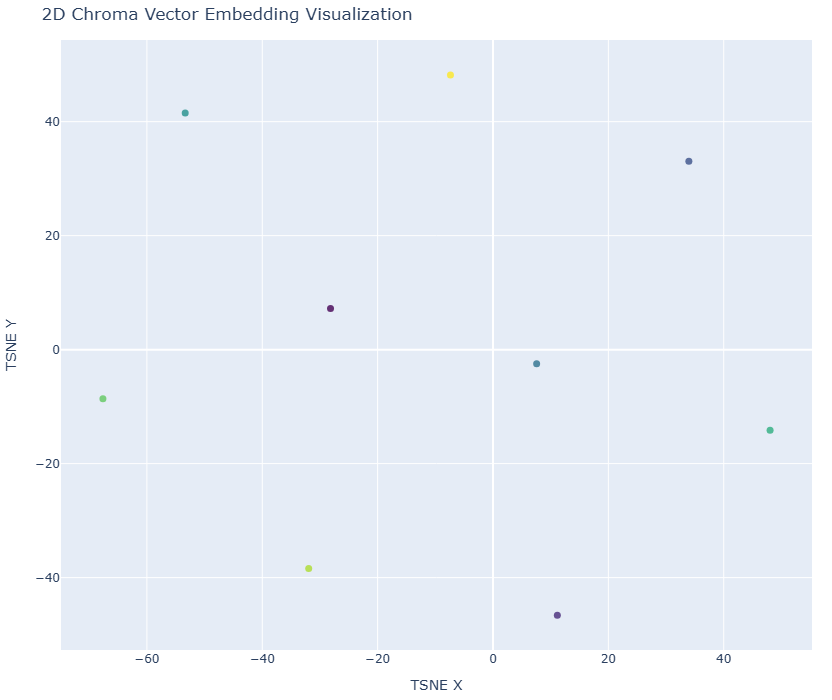

In [24]:

# Convert embeddings to NumPy array
vectors = np.array(retrieved_data['embeddings'])
documents = retrieved_data['documents']

# Ensure perplexity is valid
perplexity_value = min(10, max(1, len(vectors) - 1))

# Apply t-SNE for 2D dimensionality reduction
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=7, opacity=0.8, color=np.linspace(0, 1, len(reduced_vectors)), colorscale='Viridis'),
    text=[f"{d[:100]}..." for d in documents],# Show first 100 chars on hover
    hoverinfo='text'
)])

# Update layout for better visualization
fig.update_layout(
    title="2D Chroma Vector Embedding Visualization",
    xaxis_title="TSNE X",
    yaxis_title="TSNE Y",
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

# Show the plot
fig.show()

## <span style = "font-family: Great Vibes, cursive"> 📊 3D</snap>

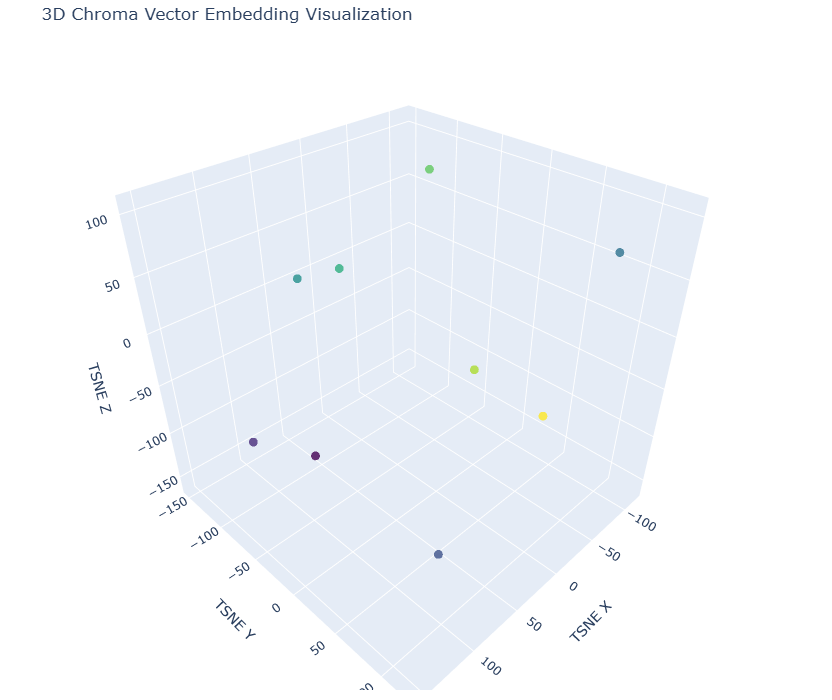

In [25]:

# Convert embeddings to NumPy array
vectors = np.array(retrieved_data['embeddings'])
documents = retrieved_data['documents']

# Ensure perplexity is valid
perplexity_value = min(10, max(1, len(vectors) - 1))

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=3, perplexity=perplexity_value, random_state=42)
reduced_vectors = tsne.fit_transform(vectors)

# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    z=reduced_vectors[:, 2],
    mode='markers',
    marker=dict(size=5, opacity=0.8, color=np.linspace(0, 1, len(reduced_vectors)), colorscale='Viridis'),
    text=[f"Text: {d[:100]}..." for d in documents],  # Show first 100 chars on hover
    hoverinfo='text'
)])

# Update layout
fig.update_layout(
    title="3D Chroma Vector Embedding Visualization",
    scene=dict(
        xaxis_title="TSNE X",
        yaxis_title="TSNE Y",
        zaxis_title="TSNE Z"
    ),
    width=900,
    height=700,
    margin=dict(r=20, b=10, l=10, t=40)
)

# Show the plot
fig.show()
